# 주문횟수 및 unique점포를 이용한 ITEM-BASED CF

## 1. 필요한 패키지 불러오기 Pandas, Numpy 등

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, euclidean, mahalanobis

## 2. 데이터 불러오기

In [2]:
df1 = pd.read_csv("C:\\Users\\tkim29\\assist_python\\recomm._sys\\p_data.csv",
                         encoding = "cp949") 
##대표님 주신 자료 csv파일 불러오기, 인코딩은 cp949로하니까 이슈 해결됨

df1["ord_fre"]=np.repeat(1,len(df1))
##<<-- order frequency 컬럼 추가. 1로 채워서 열 개수 맞춤
#df1["FC_code"]=  [x.replace("<","").replace(">","") for x in df1.FC_code]

In [41]:
df1.head()

,order_data,FC_code,FC_name,ST_code,ct_L_code,ct_L_name,ct_M_code,ct_M_name,ct_S_code,ct_S_name,sku_diff,sku_code,qty,std,ord_fre
0,2018-12-07,10241,caf?_37,16444,10,가공식품,15,조미식품,11,조미료,범용,120165,5.0,BOX,1
1,2018-12-07,10241,caf?_37,16444,10,가공식품,10,유가공품,13,치즈류,범용,100323,1.0,EA,1
2,2018-12-07,10241,caf?_37,16444,10,가공식품,19,캔/김치/편의식/기타,10,캔제품,범용,100479,24.0,EA,1
3,2018-12-07,10241,caf?_37,16444,10,가공식품,13,분말가공,12,곡물가공기타,범용,104176,12.0,EA,1
4,2018-12-07,10241,caf?_37,16444,10,가공식품,19,캔/김치/편의식/기타,13,가공식품기타,범용,119183,4.0,EA,1


In [4]:
only = df1[df1.sku_diff!="범용"] ## 범용이 아닌 상품(전용, 위탁)을 only로
only.head()

,order_data,FC_code,FC_name,ST_code,ct_L_code,ct_L_name,ct_M_code,ct_M_name,ct_S_code,ct_S_name,sku_diff,sku_code,qty,std,ord_fre
39,2018-12-06,10237,caf?_36,16404,10,가공식품,14,커피자재,12,파우더,전용,123051,10.0,EA,1
40,2018-12-06,10237,caf?_36,16404,10,가공식품,15,조미식품,12,소스/드레싱류,전용,123053,5.0,EA,1
41,2018-12-06,10237,caf?_36,16404,10,가공식품,15,조미식품,12,소스/드레싱류,전용,123054,5.0,EA,1
42,2018-12-06,10237,caf?_36,16404,10,가공식품,19,캔/김치/편의식/기타,12,편의식품,전용,123055,10.0,EA,1
43,2018-12-06,10237,caf?_36,16404,10,가공식품,19,캔/김치/편의식/기타,12,편의식품,전용,123056,10.0,EA,1


In [5]:
every = df1[df1.sku_diff=="범용"] ## 범용인 상품을 every로
every.head()

,order_data,FC_code,FC_name,ST_code,ct_L_code,ct_L_name,ct_M_code,ct_M_name,ct_S_code,ct_S_name,sku_diff,sku_code,qty,std,ord_fre
0,2018-12-07,10241,caf?_37,16444,10,가공식품,15,조미식품,11,조미료,범용,120165,5.0,BOX,1
1,2018-12-07,10241,caf?_37,16444,10,가공식품,10,유가공품,13,치즈류,범용,100323,1.0,EA,1
2,2018-12-07,10241,caf?_37,16444,10,가공식품,19,캔/김치/편의식/기타,10,캔제품,범용,100479,24.0,EA,1
3,2018-12-07,10241,caf?_37,16444,10,가공식품,13,분말가공,12,곡물가공기타,범용,104176,12.0,EA,1
4,2018-12-07,10241,caf?_37,16444,10,가공식품,19,캔/김치/편의식/기타,13,가공식품기타,범용,119183,4.0,EA,1


In [6]:
df11 = df1.pivot_table(index="ST_code",columns="sku_code",values="ord_fre",aggfunc=np.sum)
## <<-sku_code별 각 스토어의 주문량을 펼쳐서 보여줌
df11.head()

sku_code,100008,100015,100021,100028,100033,100054,100067,100072,100080,100081,...,123241,123242,123244,123245,123246,123248,123249,123254,123255,123285
ST_code,,,,,,,,,,,,,,,,,,,,,
10016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10020,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df22 = pd.DataFrame(df11.sum())
##<<-- sku_code 별 주문수량의 합
df22.columns = ["orders"]
##<<-- df22의 컬럼명을 orders로 지정
df22.head()

,orders
sku_code,
100008,10.0
100015,520.0
100021,1.0
100028,2.0
100033,12.0


## 3. Unique점포 수 구하기

In [8]:
unique점포1 = []
for i2 in df11.columns:
    tt1 = df11[i2].dropna()
    u1 = len(tt1)
    unique점포1 += [u1]
df22["unique shop"]=unique점포1
##df22에는 orders컬럼뿐이었으나 unique shop 컬럼을 추가함. 구성은 위에 For 문으로.. 채움

In [9]:
df22.head() 
##sku_code 별 주문량 및 unique shop 수

,orders,unique shop
sku_code,,
100008,10.0,7
100015,520.0,118
100021,1.0,1
100028,2.0,2
100033,12.0,8


# 유사도 거리측정 공식 적용

## 1.코사인거리

In [10]:
## 유사도 거리측정 (코사인거리)
cosin1 = pairwise_distances(np.array(df22),metric = 'cosine')
cosin_df = pd.DataFrame(cosin1)
cosin_df.columns = df22.index
cosin_df.index = df22.index

In [11]:
cosin_df.head()

sku_code,100008,100015,100021,100028,100033,100054,100067,100072,100080,100081,...,123241,123242,123244,123245,123246,123248,123249,123254,123255,123285
sku_code,,,,,,,,,,,,,,,,,,,,,
100008,0.000000,0.074174,1.521644e-02,1.521644e-02,0.000258,0.010797,1.521644e-02,0.015216,0.010797,0.021109,...,1.521644e-02,1.521644e-02,1.521644e-02,1.521644e-02,1.521644e-02,1.521644e-02,1.521644e-02,0.015216,0.006526,1.521644e-02
100015,0.074174,0.000000,1.539444e-01,1.539444e-01,0.065826,0.028782,1.539444e-01,0.153944,0.028782,0.016471,...,1.539444e-01,1.539444e-01,1.539444e-01,1.539444e-01,1.539444e-01,1.539444e-01,1.539444e-01,0.153944,0.037109,1.539444e-01
100021,0.015216,0.153944,0.000000e+00,2.220446e-16,0.019419,0.051317,2.220446e-16,0.000000,0.051317,0.071523,...,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,0.000000,0.041464,2.220446e-16
100028,0.015216,0.153944,2.220446e-16,0.000000e+00,0.019419,0.051317,2.220446e-16,0.000000,0.051317,0.071523,...,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,0.000000,0.041464,2.220446e-16
100033,0.000258,0.065826,1.941932e-02,1.941932e-02,0.000000,0.007722,1.941932e-02,0.019419,0.007722,0.016718,...,1.941932e-02,1.941932e-02,1.941932e-02,1.941932e-02,1.941932e-02,1.941932e-02,1.941932e-02,0.019419,0.004191,1.941932e-02


In [12]:
## 함수rec_cos 정의
def rec_cos(x,fc):
    df2 = only[only["FC_code"]==fc].append(every) ##비범용(범용이아닌) 상점의 프랜차이즈 코드
    df5 = df2.loc[:,["FC_code","ST_code","sku_code","ct_S_code","sku_diff"]]
    df5 = df5.drop_duplicates()
    
    new_df = pd.DataFrame({"a":cosin_df.index,"b":cosin_df.iloc[:,0]})
    new_df.columns = ["sku_code","distance"]
    
    new_df2 = df5.merge(new_df,on = "sku_code", how = "left")
    
    cat1 = new_df2.ct_S_code[new_df2["sku_code"]==x].unique()[0]
    new_df2 = new_df2[new_df2["sku_code"]!=x]
    cats = new_df2[new_df2.ct_S_code==cat1].sort_values("distance",ascending=True)
    catd = new_df2[new_df2.ct_S_code!=cat1].sort_values("distance",ascending=True)
    df1.sku_code[df1["sku_code"]==x], df1.FC_code[df1["FC_code"]==fc]
    return(cats,catd)

## 2. 유클리디언 거리

In [13]:
## 유사도 거리측정 (유클리디언 거리)
euclidean1 = pairwise_distances(np.array(df22),metric = 'euclidean')
#euclidean2 = 1/(1+euclidean1) ## 1에가까울수록 유사도가 높은식으로 공식변경가능 (1/(1+d))
euclidean_df = pd.DataFrame(euclidean1)
euclidean_df.columns = df22.index
euclidean_df.index = df22.index

In [14]:
euclidean_df.head()

sku_code,100008,100015,100021,100028,100033,100054,100067,100072,100080,100081,...,123241,123242,123244,123245,123246,123248,123249,123254,123255,123285
sku_code,,,,,,,,,,,,,,,,,,,,,
100008,0.000000,521.939652,10.816654,9.433981,2.236068,10.000000,10.816654,8.062258,10.000000,4.123106,...,10.816654,10.816654,10.816654,10.816654,10.816654,10.816654,10.816654,4.123106,15.231546,64.381674
100015,521.939652,0.000000,532.024436,530.829539,519.773027,531.048962,532.024436,529.635724,531.048962,518.247045,...,532.024436,532.024436,532.024436,532.024436,532.024436,532.024436,532.024436,526.060833,506.992110,470.374319
100021,10.816654,532.024436,0.000000,1.414214,13.038405,1.000000,0.000000,2.828427,1.000000,13.928388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.071068,25.942244,74.953319
100028,9.433981,530.829539,1.414214,0.000000,11.661904,1.000000,1.414214,1.414214,1.000000,12.649111,...,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,5.656854,24.596748,73.539105
100033,2.236068,519.773027,13.038405,11.661904,0.000000,12.206556,13.038405,10.295630,12.206556,2.828427,...,13.038405,13.038405,13.038405,13.038405,13.038405,13.038405,13.038405,6.324555,13.000000,62.289646


In [15]:
## 함수rec_euc 정의
def rec_euc(x,fc):
    df2 = only[only["FC_code"]==fc].append(every) ##비범용(범용이아닌) 상점의 프랜차이즈 코드
    df5 = df2.loc[:,["FC_code","ST_code","sku_code","ct_S_code","sku_diff"]]
    df5 = df5.drop_duplicates()
    new_df = pd.DataFrame({"a":euclidean_df.index,"b":euclidean_df.iloc[:,0]})
    new_df.columns = ["sku_code","distance"]
    new_df2 = df5.merge(new_df,on = "sku_code", how = "left")
    cat1 = new_df2.ct_S_code[new_df2["sku_code"]==x].unique()[0]
    new_df2 = new_df2[new_df2["sku_code"]!=x]
    cats = new_df2[new_df2.ct_S_code==cat1].sort_values("distance",ascending=True)
    catd = new_df2[new_df2.ct_S_code!=cat1].sort_values("distance",ascending=True)
    df1.sku_code[df1["sku_code"]==x], df1.FC_code[df1["FC_code"]==fc]
    return(cats,catd)

## 3.마할라노비스 거리

In [16]:
## 유사도 거리측정 (마할라노비스 거리)
mahalanobis1 = pairwise_distances(np.array(df22),metric = 'mahalanobis')
mahalanobis_df = pd.DataFrame(mahalanobis1)
mahalanobis_df.columns = df22.index
mahalanobis_df.index = df22.index

In [17]:
mahalanobis_df.head()

sku_code,100008,100015,100021,100028,100033,100054,100067,100072,100080,100081,...,123241,123242,123244,123245,123246,123248,123249,123254,123255,123285
sku_code,,,,,,,,,,,,,,,,,,,,,
100008,0.000000,3.437069,0.216582,0.178025,0.033805,0.221704,0.216582,0.139590,0.221704,0.075673,...,0.216582,0.216582,0.216582,0.216582,0.216582,0.216582,0.216582,0.030084,0.195195,1.839635
100015,3.437069,0.000000,3.585027,3.560834,3.411974,3.583199,3.585027,3.536900,3.583199,3.449649,...,3.585027,3.585027,3.585027,3.585027,3.585027,3.585027,3.585027,3.466710,3.283704,2.798812
100021,0.216582,3.585027,0.000000,0.038775,0.250208,0.008980,0.000000,0.077551,0.008980,0.158408,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.193877,0.409880,2.055094
100028,0.178025,3.560834,0.038775,0.000000,0.211716,0.045006,0.038775,0.038775,0.045006,0.122852,...,0.038775,0.038775,0.038775,0.038775,0.038775,0.038775,0.038775,0.155101,0.371854,2.016318
100033,0.033805,3.411974,0.250208,0.211716,0.000000,0.255205,0.250208,0.173351,0.255205,0.104093,...,0.250208,0.250208,0.250208,0.250208,0.250208,0.250208,0.250208,0.061426,0.161526,1.806646


In [18]:
## 함수rec_mks 정의
def rec_mahlbs(x,fc):
    df2 = only[only["FC_code"]==fc].append(every) ##비범용(범용이아닌) 상점의 프랜차이즈 코드
    df5 = df2.loc[:,["FC_code","ST_code","sku_code","ct_S_code","sku_diff"]]
    df5 = df5.drop_duplicates()
    
    new_df = pd.DataFrame({"a":mahalanobis_df.index,"b":mahalanobis_df.iloc[:,0]})
    new_df.columns = ["sku_code","distance"]
    
    new_df2 = df5.merge(new_df,on = "sku_code", how = "left")
    cat1 = new_df2.ct_S_code[new_df2["sku_code"]==x].unique()[0]
    new_df2 = new_df2[new_df2["sku_code"]!=x]
    
    cats = new_df2[new_df2.ct_S_code==cat1].sort_values("distance",ascending=True)
    catd = new_df2[new_df2.ct_S_code!=cat1].sort_values("distance",ascending=True)
    
    df1.sku_code[df1["sku_code"]==x], df1.FC_code[df1["FC_code"]==fc]
    
    return(cats,catd)

#### 기타.. 거리측정 옵션들..
Unknown metric eucliden. Valid metrics are ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski'], or 'precomputed', or a callable

## SKU code 및 FC code 인풋처리

In [42]:
input_sku_code = int(input("sku_code 6자리를 입력하세요")) #121605
input_fc_code = int(input("FC_code 5자리를 입력하세요")) #20208

sku_code 6자리를 입력하세요121605
FC_code 5자리를 입력하세요20208


In [43]:
print("{입력된 SKU_CODE =", input_sku_code,"}","/",
      "{입력된 FC_CODE =", input_fc_code,"}")

{입력된 SKU_CODE = 121605 } / {입력된 FC_CODE = 20208 }


In [44]:
sim_cos,dissim_cos = rec_cos(input_sku_code,input_fc_code) ## rec(x=sku_code, fc=fc_cde 입력)
sim_euc,dissim_euc = rec_euc(input_sku_code,input_fc_code)
sim_mahlbs,dissim_mahlbs = rec_mahlbs(input_sku_code,input_fc_code)

##### - sim은 같은 카테고리(ct_S_code)의 상품 추천, dissim은 다른 카테코리의 상품 추천

## 1. 코사인거리 적용결과

In [45]:
result_simcos = sim_cos.head(20) ##같은카테고리 상품추천 (ct_S_code 가 동일)
result_simcos

,FC_code,ST_code,sku_code,ct_S_code,sku_diff,distance
584,10230,16301,122517,12,범용,0.000000
16166,10234,16425,100008,12,범용,0.000000
987,10230,16138,122517,12,범용,0.000000
894,10230,16145,122517,12,범용,0.000000
867,10230,16141,122517,12,범용,0.000000
38168,10139,13084,100008,12,범용,0.000000
846,10230,16483,122517,12,범용,0.000000
735,10230,16465,122517,12,범용,0.000000
33239,10170,13833,100008,12,범용,0.000000
12183,10160,15562,100008,12,범용,0.000000


In [29]:
result_dissimcos = dissim_cos.head(20) ##다른 카테고리 상품추천 (ct_S_code가 다름)
result_dissimcos

,FC_code,ST_code,sku_code,ct_S_code,sku_diff,distance
27209,10203,15266,120330,13,범용,0.0
43932,10202,15865,119822,10,범용,0.0
29575,10129,15391,110749,14,범용,0.0
44011,10202,15193,119822,10,범용,0.0
26027,10182,14337,110749,14,범용,0.0
29588,10129,15391,106985,14,범용,0.0
18252,10226,15972,121621,15,범용,0.0
26229,10203,15235,120330,13,범용,0.0
19275,10226,15985,121621,15,범용,0.0
19332,10226,15978,121621,15,범용,0.0


## 2. 유클리디안 거리 적용결과

In [30]:
result_simeuc = sim_euc.head(20)
result_simeuc

,FC_code,ST_code,sku_code,ct_S_code,sku_diff,distance
34572,10170,15700,100008,12,범용,0.0
584,10230,16301,122517,12,범용,0.0
894,10230,16145,122517,12,범용,0.0
735,10230,16465,122517,12,범용,0.0
551,10230,16300,122517,12,범용,0.0
987,10230,16138,122517,12,범용,0.0
16166,10234,16425,100008,12,범용,0.0
33239,10170,13833,100008,12,범용,0.0
38168,10139,13084,100008,12,범용,0.0
867,10230,16141,122517,12,범용,0.0


In [31]:
result_dissimeuc= dissim_euc.head(20)
result_dissimeuc

,FC_code,ST_code,sku_code,ct_S_code,sku_diff,distance
26305,10203,16443,119555,10,범용,0.0
26949,10203,15259,120330,13,범용,0.0
16571,10234,16508,108630,10,범용,0.0
1199,10192,14678,108630,10,범용,0.0
26973,10203,15238,120330,13,범용,0.0
26291,10203,16443,120330,13,범용,0.0
37051,10044,15694,108774,11,범용,0.0
26229,10203,15235,120330,13,범용,0.0
2872,10222,16033,106985,14,범용,0.0
11489,10007,14822,100400,11,범용,0.0


## 3.마할라노비스 거리 적용결과

In [34]:
result_simmahlbs = sim_mahlbs.head(20)
result_simmahlbs

,FC_code,ST_code,sku_code,ct_S_code,sku_diff,distance
34572,10170,15700,100008,12,범용,0.000000
551,10230,16300,122517,12,범용,0.000000
33239,10170,13833,100008,12,범용,0.000000
33289,10170,14152,100008,12,범용,0.000000
735,10230,16465,122517,12,범용,0.000000
34569,10170,15321,100008,12,범용,0.000000
38168,10139,13084,100008,12,범용,0.000000
846,10230,16483,122517,12,범용,0.000000
867,10230,16141,122517,12,범용,0.000000
16166,10234,16425,100008,12,범용,0.000000


In [33]:
result_dissimmahlbs = dissim_mahlbs.head(20)
result_dissimmahlbs

,FC_code,ST_code,sku_code,ct_S_code,sku_diff,distance
26942,10203,15271,120330,13,범용,0.0
45048,10202,15183,119822,10,범용,0.0
26949,10203,15259,120330,13,범용,0.0
26973,10203,15238,120330,13,범용,0.0
27003,10203,15259,119555,10,범용,0.0
16188,10234,14851,108630,10,범용,0.0
27190,10203,15241,119555,10,범용,0.0
27209,10203,15266,120330,13,범용,0.0
27241,10203,15238,108630,10,범용,0.0
16099,10234,16420,108630,10,범용,0.0


## 상기 적용한 3가지 유사도 거리 모두 합쳐서 추천

In [35]:
result_total_sim = pd.concat([result_simcos,result_simeuc,result_simmahlbs], axis=0)

In [36]:
result_total_sim.sort('distance', ascending=True)

C:\Users\tkim29\AppData\Local\Continuum\Anaconda3.4.2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,FC_code,ST_code,sku_code,ct_S_code,sku_diff,distance
584,10230,16301,122517,12,범용,0.000000
16166,10234,16425,100008,12,범용,0.000000
33239,10170,13833,100008,12,범용,0.000000
38168,10139,13084,100008,12,범용,0.000000
846,10230,16483,122517,12,범용,0.000000
34569,10170,15321,100008,12,범용,0.000000
12183,10160,15562,100008,12,범용,0.000000
33289,10170,14152,100008,12,범용,0.000000
34572,10170,15700,100008,12,범용,0.000000
551,10230,16300,122517,12,범용,0.000000


In [37]:
result_total_dissim = pd.concat([result_dissimcos,result_dissimeuc,result_dissimmahlbs], axis=0)

In [38]:
result_total_dissim.sort('distance', ascending=True)

C:\Users\tkim29\AppData\Local\Continuum\Anaconda3.4.2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,FC_code,ST_code,sku_code,ct_S_code,sku_diff,distance
27209,10203,15266,120330,13,범용,0.0
27003,10203,15259,119555,10,범용,0.0
26309,10203,16443,108630,10,범용,0.0
29224,10129,16348,108630,10,범용,0.0
27487,10203,15258,120330,13,범용,0.0
11651,10007,12282,100400,11,범용,0.0
11691,10007,12054,100400,11,범용,0.0
26027,10182,14337,110749,14,범용,0.0
27522,10203,15607,119555,10,범용,0.0
26942,10203,15271,120330,13,범용,0.0


# 모델기반 추천엔진의 종류

### 1. 확률적 접근법:
사용 가능한 데이터로부터 사전 확률(prior)을 이용해 확률 모델을 생성하고 각 사용자의 제품에 대한 좋고 싫음의 확률을 계산하여 추천 순위 리스트를 생성합니다.
가장 흔히 사용되는 방식은 나이브 베이즈 방식으로 간단하지만 강력한 기법입니다.

### 2. 머신 러닝 접근법:
로지스틱 회구, KNN 분류, 결정 트리, SVM, 클러스터링 등과 같은 다양한 머신 러닝 기법을 사용하여 추천 엔진에 도입시키는 방법입니다.

### 3. 수학적 접근법
가장 흔히 사용되는 방법은 행렬 인수 분해 모델과 특이값 분해 모델 입니다. 행렬 인수 분해는 기존 평가 행렬 R을 사용자와 잠재 특징을 나타내는 두 개의 새로운 행렬 U와 V로 분해하는 방법입니다.
수학적 방식에서는 하나의 행렬을 계수가 낮은 두 개의 행렬로 분해가 가능하다는 점을 이용하여 적절한 최적화를 통해 행렬 값을 구할 수 있습니다.

## K-Means Clustering


In [201]:

from sklearn.cluster import KMeans

import matplotlib.pyplot  as plt

import seaborn as sns

df22.head() 

feature = df22

feature.head()


,orders,unique shop
sku_code,,
100008,10.0,7
100015,520.0,118
100021,1.0,1
100028,2.0,2
100033,12.0,8


In [237]:
# create model and prediction

model = KMeans(n_clusters=3,algorithm='auto')

model.fit(df22)

predict.columns=['predict']

In [238]:
r = pd.concat([df22,predict],axis=1)
r.head()

,orders,unique shop,predict
0,NaN,NaN,0.0
1,NaN,NaN,1.0
2,NaN,NaN,0.0
3,NaN,NaN,0.0
4,NaN,NaN,0.0


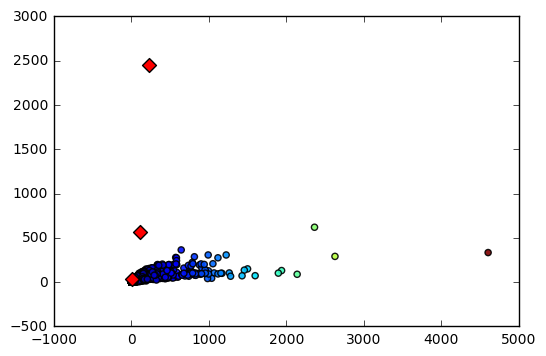

In [239]:
plt.scatter(r['orders'],r['unique shop'],c=r['orders'],alpha=0.9)

centers = pd.DataFrame(model.cluster_centers_,columns=['orders','unique shop'])

center_x = centers['unique shop']

center_y = centers['orders']

plt.scatter(center_x,center_y,s=50,marker='D',c='r')

plt.show()

In [229]:
##feature scaling
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans



scaler = StandardScaler()

model = KMeans(n_clusters=3)

pipeline = make_pipeline(scaler,model)

In [230]:
pipeline.fit(feature)

predict = pd.DataFrame(pipeline.predict(feature))

C:\Users\tkim29\AppData\Local\Continuum\Anaconda3.4.2\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\tkim29\AppData\Local\Continuum\Anaconda3.4.2\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\tkim29\AppData\Local\Continuum\Anaconda3.4.2\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


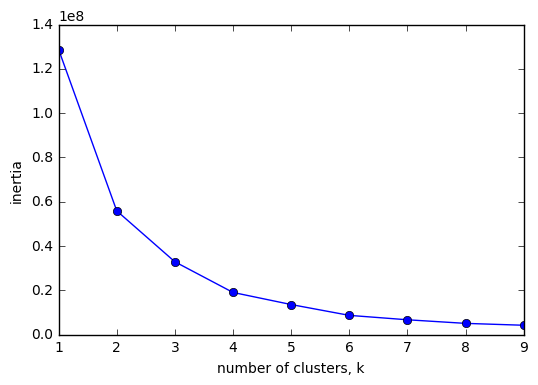

In [231]:
#inertia value를 이용한 적정 군집수 판단
ks = range(1,10)

inertias = []



for k in ks:

    model = KMeans(n_clusters=k)

    model.fit(feature)

    inertias.append(model.inertia_)

    

# Plot ks vs inertias

plt.plot(ks, inertias, '-o')

plt.xlabel('number of clusters, k')

plt.ylabel('inertia')

plt.xticks(ks)

plt.show()
